In [1]:
# Import relevant packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from openpyxl import Workbook
from openpyxl.chart import ScatterChart, Reference, Series
from openpyxl.drawing.image import Image
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.utils import get_column_letter
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.worksheet.table import Table, TableStyleInfo
from openpyxl.styles import PatternFill

In [2]:
# Read in the dataset 
websites = pd.read_excel('websites.xlsx')

In [3]:
# Print first five rows
websites.head()

,url,category,rating,visitors
0,https://www.example.com,News,4.5,10000.0
1,https://www.invalidurl,Technology,3.2,5000.0
2,https://www.openai.org,Finance,4.8,20000.0
3,https://www.example2.com,Education,4.2,15000.0
4,https://www.invalidurl2,News,2.9,3000.0


In [4]:
# Find number of rows, columns, data types, and so forth
websites.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   url       34 non-null     object 
 1   category  34 non-null     object 
 2   rating    32 non-null     float64
 3   visitors  32 non-null     float64
dtypes: float64(2), object(2)
memory usage: 1.2+ KB


In [5]:
# Drop rows with bad URL

## Create regular expressions pattern 
url_pattern = r'^(?:(?:https?|ftp):\/\/)?(?:www\.)?[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}(?:\/[^\s]*)?$'

## Keep only rows matching pattern 
valid_urls = websites[websites['url'].str.contains(url_pattern)]

# Check resulting DataFrame
valid_urls.shape

(28, 4)

In [6]:
# Sort missing values by column from high to low
valid_urls.isnull().mean().sort_values(ascending=False)

visitors    0.071429
url         0.000000
category    0.000000
rating      0.000000
dtype: float64

In [7]:
# Drop remaining missing values
complete_cases = valid_urls.dropna()

# Check results
complete_cases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26 entries, 0 to 33
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   url       26 non-null     object 
 1   category  26 non-null     object 
 2   rating    26 non-null     float64
 3   visitors  26 non-null     float64
dtypes: float64(2), object(2)
memory usage: 1.0+ KB


In [8]:
# Create worksheet and workbook objects in openpyxl

wb = Workbook()
ws = wb.active
ws.title = 'summary'

In [9]:
# Generate a summary worksheet 
ws['A1'] = 'Total number of websites'
ws['B1'] = len(complete_cases)

In [10]:
ws['A2'] = 'Total number of visitors'
ws['B2'] = round(complete_cases['visitors'].sum())

In [11]:
ws['A3'] = 'Average number of visitors'
ws['B3'] = round(complete_cases['rating'].mean(), 2)

In [12]:
# Widen Column A
ws.column_dimensions['A'].width = 40

In [13]:
# Apply thousands separator format to `B2`
thousands_format = '#,##0'
ws['B2'].number_format = thousands_format

In [14]:
# Add DataFrame to new worksheet

ws2 = wb.create_sheet(title='data')

for row in dataframe_to_rows(complete_cases, index=False, header=True):
    ws2.append(row)

In [15]:
# Autofit the dataset widths

for column in ws2.columns:
    max_length = 0
    column = list(column)
    for cell in column:
        try:
            if len(str(cell.value)) > max_length:
                max_length = len(cell.value)
        except:
            pass
    adjusted_width = (max_length + 2) * 1.2
    ws2.column_dimensions[column[0].column_letter].width = adjusted_width

In [16]:
# Add table

# Specify desired table formatting
style = TableStyleInfo(name='TableStyleMedium9', showRowStripes=True)

# Name and identify range of table
table = Table(displayName='websites',
              ref='A1:' + get_column_letter(ws2.max_column) + str(ws2.max_row))

# Apply styling and insert in worksheet
table.tableStyleInfo = style
ws2.add_table(table)

In [17]:
# Format the Visitors column in thousands

## Get the index position (convert b/w zero- and one-based)
visitors_loc = complete_cases.columns.get_loc('visitors') + 1
visitors_loc

## Loop and apply formatting 
for cell in ws2.iter_cols(min_col=visitors_loc, max_col=visitors_loc):
    for cell in cell:
        cell.number_format = thousands_format

In [18]:
# Conditionally format rows with rating over 4.5 as green

## Create green fill
green_fill = PatternFill(start_color="B9E8A2", end_color="B9E8A2", fill_type="solid")

## Identify position of rating column
rating_loc = complete_cases.columns.get_loc('rating')

## Apply formatting
for row in ws2.iter_rows(min_row=2, min_col=1, max_col=len(complete_cases.columns)):
    rating = row[rating_loc].value # Convert index to 0-based indexing
    if rating > 4.5:
        for cell in row:
            cell.fill = green_fill

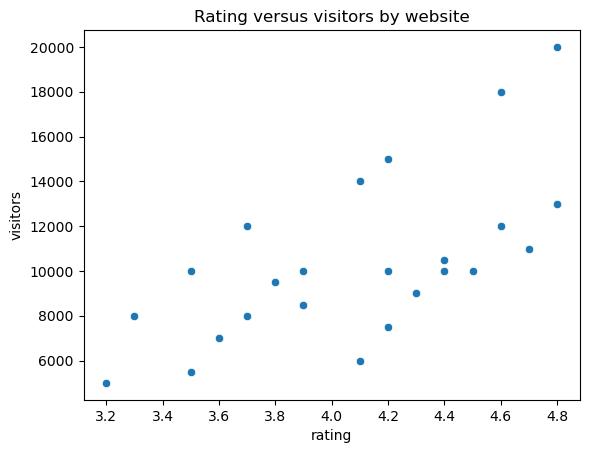

In [19]:
# Create Python scatterplot with rating on x-axis and visitors oon y

sns.scatterplot(x='rating', y='visitors', data=complete_cases)

## Add title and save plot
plt.title('Rating versus visitors by website')
plt.savefig('scatterplot.png')

## Write plot into workbook
image = Image('scatterplot.png')
ws2.add_image(image, 'G1')

In [20]:
# Save as `ch_12_exercise_solutions.xlsx` and close
wb.save('ch_12_exercise_solutions.xlsx')
wb.close()